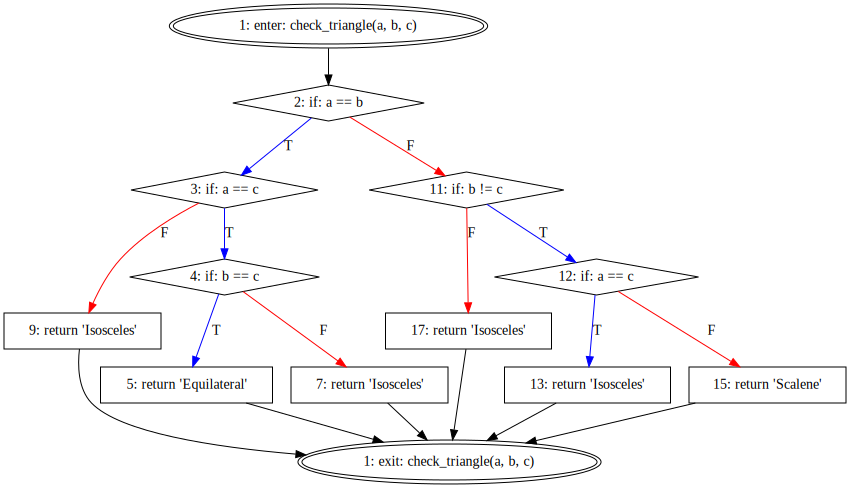

In [135]:
import inspect
from fuzzingbook.ControlFlow import PyCFG, to_graph, gen_cfg

def check_triangle(a: int, b: int, c: int) -> str:
    if a == b:
        if a == c:
            if b == c:
                return "Equilateral"
            else:
                return "Isosceles"
        else:
            return "Isosceles"
    else:
        if b != c:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"
        else:
            return "Isosceles"

def show_cfg(fn, **kwargs):
    return to_graph(gen_cfg(inspect.getsource(fn)), **kwargs)

show_cfg(check_triangle)


In [136]:
import z3 

z3_ver = z3.get_version()
print(z3_ver)

(4, 11, 2, 0)


In [137]:
def get_annotations(fn):
    sig = inspect.signature(fn)
    return ([(i.name, i.annotation) for i in sig.parameters.values()], sig.return_annotation)

params, ret = get_annotations(check_triangle)
params, ret

([('a', int), ('b', int), ('c', int)], str)

In [138]:
SYM_VARS = {
    int: (
        z3.Int, z3.IntVal), float: (
            z3.Real, z3.RealVal), str: (
                z3.String, z3.StringVal)}

def get_symbolicparams(fn):
    params, ret = get_annotations(fn)
    return [SYM_VARS[typ][0](name)
            for name, typ in params], SYM_VARS[ret][0]('__return__')
    
(a, b, c), r = get_symbolicparams(check_triangle)
a, b, c, r

z3.solve(a == b, a == c, b == c)

[a = 0, b = 0, c = 0]


In [139]:
from fuzzingbook.ConcolicFuzzer import ArcCoverage

with ArcCoverage() as cov:
    assert check_triangle(0,0,0) == 'Equilateral'

cov._trace, cov.arcs()

([('check_triangle', 4),
  ('check_triangle', 5),
  ('check_triangle', 6),
  ('check_triangle', 7),
  ('check_triangle', 8),
  ('__exit__', 262),
  ('__exit__', 263)],
 [(4, 5), (5, 6), (6, 7), (7, 8), (8, 262), (262, 263)])

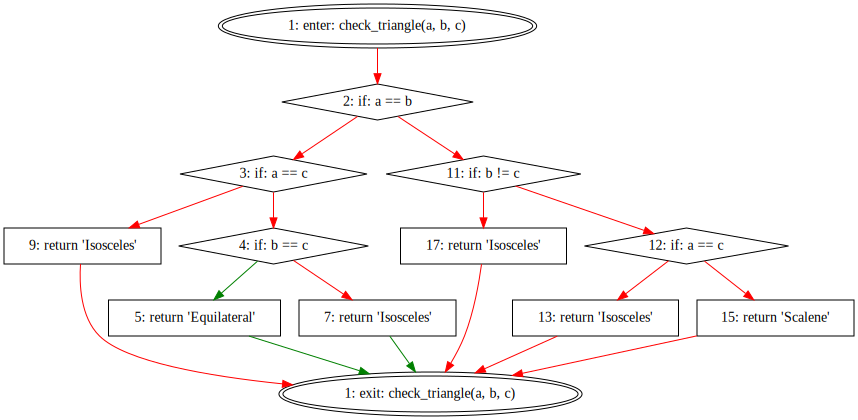

In [140]:
show_cfg(check_triangle, arcs = cov.arcs())

In [141]:
z3.solve(a==b, z3.Not(a==c))

[b = 1, c = 0, a = 1]


In [142]:
z3.solve(a==b, a==c, z3.Not(b==c))

no solution


In [143]:
with ArcCoverage() as cov:
    assert check_triangle(1,1,0) == 'Isosceles'

[i for fn, i in cov._trace if fn == 'check_triangle']

[4, 5, 6, 12]

In [144]:
paths = {
    '<path 1>': ([1, 2, 3, 4, 5], 'Equilateral'),
    '<path 2>': ([1, 2, 3, 4, 7], 'Isosceles'),
    '<path 3>': ([1, 2, 3, 9], 'Isosceles'),
    '<path 4>': ([1, 2, 11, 12, 13], 'Isosceles'),
    '<path 5>': ([1, 2, 11, 12, 15], 'Scalene'),
    '<path 6>': ([1, 2, 11, 17], 'Isosceles'),
}
paths['<path 3>']

([1, 2, 3, 9], 'Isosceles')

In [145]:
z3.solve(z3.Not(a==b), b != c, a==c)

[b = 0, c = 1, a = 1]


In [146]:
pre_condition = z3.And(a >0, b > 0, c > 0 )
z3.solve(pre_condition, z3.Not(a == b), b != c, a == c)

[c = 2, b = 1, a = 2]


In [147]:
with ArcCoverage() as cov:
    assert check_triangle(1,2,1) == 'Isosceles'

[i for fn, i in cov._trace if fn == 'check_triangle']

[4, 5, 14, 15, 16]

In [148]:
paths['<path 4>']

([1, 2, 11, 12, 13], 'Isosceles')

In [149]:
z3.solve(pre_condition, z3.Not(a == b), b != c, z3.Not(a == c))

[a = 1, c = 3, b = 2]


## Visualizing the Coverage

In [150]:
class VisualizeArcCoverage(ArcCoverage):
    def show_coverage(self, fn):
        src = fn if isinstance(fn, str) else inspect.getsource(fn)
        covered = set([lineno for method, lineno in self._trace])
        for i, s in enumerate(src.split('\n')):
            print('%s %2d: %s' % ('#' if i + 1 in covered else ' ', i + 1, s))

with VisualizeArcCoverage() as cov:
    assert check_triangle(0, 0, 0) == 'Equilateral'
    assert check_triangle(1, 1, 0) == 'Isosceles'
    assert check_triangle(1, 2, 1) == 'Isosceles'
    assert check_triangle(3, 1, 2) == 'Scalene'
    assert check_triangle(2, 1, 1) == 'Isosceles'

cov.show_coverage(check_triangle)

   1: def check_triangle(a: int, b: int, c: int) -> str:
   2:     if a == b:
   3:         if a == c:
#  4:             if b == c:
#  5:                 return "Equilateral"
#  6:             else:
#  7:                 return "Isosceles"
#  8:         else:
   9:             return "Isosceles"
  10:     else:
  11:         if b != c:
# 12:             if a == c:
  13:                 return "Isosceles"
# 14:             else:
# 15:                 return "Scalene"
# 16:         else:
  17:             return "Isosceles"
# 18: 


## Function Summaries

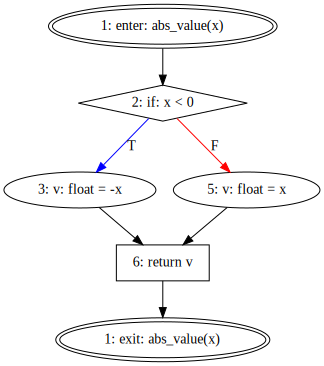

In [151]:
def abs_value(x: float) -> float:
    if x < 0:
        v: float = -x
    else:
        v: float = x
    return v

show_cfg(abs_value)

In [152]:
(x, ), r = get_symbolicparams(abs_value)

In [153]:
l2_T = x < 0
l2_F = z3.Not(x < 0)

In [154]:
v_0 = z3.Real('v_0')
l3 = z3.And(l2_T, v_0 == -x)

v_1 = z3.Real('v_1')
l5 = z3.And(l2_F, v_1 == x)

In [155]:
v = z3.Real('v')
for s in [z3.And(l3, v == v_0), z3.And(l5, v == v_1)]:
    z3.solve(x!=0, s)

[x = -1/2, v_0 = 1/2, v = 1/2]
[v_1 = 1, x = 1, v = 1]


In [156]:
v = z3.Real('v')
l6 = z3.Or(z3.And(l3, v ==v_0), z3.And(l5, v == v_1))
z3.solve(l6)

[v_1 = 0, x = 0, v_0 = -1/2, v = 0]


In [157]:
s = z3.Solver()
s.add(l6)
for i in range(5):
    if s.check() == z3.sat:
        m = s.model()
        x_val = m[x]
        print(m)
    else:
        print('no solution')
        break
    s.add(z3.Not(x == x_val))
s

[v_1 = 0, x = 0, v_0 = 1/2, v = 0]
[x = -1/2, v_0 = 1/2, v = 1/2]
[x = -3/2, v_0 = 3/2, v = 3/2]
[x = -5/2, v_0 = 5/2, v = 5/2]
[x = -7/2, v_0 = 7/2, v = 7/2]


[Or(And(And(x < 0, v_0 == -x), v == v_0),
    And(And(Not(x < 0), v_1 == x), v == v_1)),
 Not(0 == x),
 Not(-1/2 == x),
 Not(-3/2 == x),
 Not(-5/2 == x),
 Not(-7/2 == x)]

In [158]:
s.add(x < 0)
for i in range(5):
    if s.check() == z3.sat:
        m = s.model()
        x_val = m[x]
        print(m)
    else:
        print('no solution')
        break
    s.add(z3.Not(x == x_val))

[x = -9/2, v_0 = 9/2, v = 9/2]
[x = -11/2, v_0 = 11/2, v = 11/2]
[x = -13/2, v_0 = 13/2, v = 13/2]
[x = -15/2, v_0 = 15/2, v = 15/2]
[x = -17/2, v_0 = 17/2, v = 17/2]


In [159]:
s

[Or(And(And(x < 0, v_0 == -x), v == v_0),
    And(And(Not(x < 0), v_1 == x), v == v_1)),
 Not(0 == x),
 Not(-1/2 == x),
 Not(-3/2 == x),
 Not(-5/2 == x),
 Not(-7/2 == x),
 x < 0,
 Not(-9/2 == x),
 Not(-11/2 == x),
 Not(-13/2 == x),
 Not(-15/2 == x),
 Not(-17/2 == x)]

In [160]:
import ast

xy_ast = ast.parse('x+y')

In [161]:
from fuzzingbook.bookutils import rich_output

if rich_output():
    # Normally, this will do
    from showast import show_ast
else:
    def show_ast(tree):
        ast.dump(tree, indent=4)

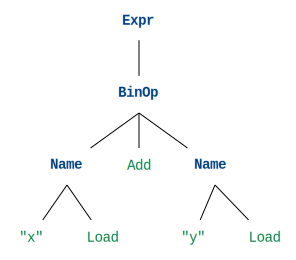

In [162]:
show_ast(xy_ast)

In [163]:
def get_expression(src):
    return ast.parse(src).body[0].value

e = get_expression('x+y')
e

In [164]:
import astunparse
def to_src(astnode):
    return astunparse.unparse(astnode).strip()

to_src(e)

'(x + y)'

In [165]:
env = {'x':1}
def prefix_vars(astnode, prefix):
    if isinstance(astnode, ast.BoolOp):
        return ast.BoolOp(astnode.op,
                          [prefix_vars(i, prefix) for i in astnode.values], [])
    elif isinstance(astnode, ast.BinOp):
        return ast.BinOp(
            prefix_vars(astnode.left, prefix), astnode.op,
            prefix_vars(astnode.right, prefix))
    elif isinstance(astnode, ast.UnaryOp):
        return ast.UnaryOp(astnode.op, prefix_vars(astnode.operand, prefix))
    elif isinstance(astnode, ast.Call):
        return ast.Call(prefix_vars(astnode.func, prefix),
                        [prefix_vars(i, prefix) for i in astnode.args],
                        astnode.keywords)
    elif isinstance(astnode, ast.Compare):
        return ast.Compare(
            prefix_vars(astnode.left, prefix), astnode.ops,
            [prefix_vars(i, prefix) for i in astnode.comparators])
    elif isinstance(astnode, ast.Name):
        if astnode.id in {'And', 'Or', 'Not'}:
            return ast.Name('z3.%s' % (astnode.id), astnode.ctx)
        else:
            return ast.Name('%s%s' % (prefix, astnode.id), astnode.ctx)
    elif isinstance(astnode, ast.Return):
        return ast.Return(prefix_vars(astnode.value, env))
    else:
        return astnode

abs_value_summary = l6
abs_value_summary_ast = get_expression(str(abs_value_summary))
print(to_src(prefix_vars(abs_value_summary_ast, 'x1_')))

z3.Or(z3.And(z3.And((x1_x < 0), (x1_v_0 == (- x1_x))), (x1_v == x1_v_0)), z3.And(z3.And(z3.Not((x1_x < 0)), (x1_v_1 == x1_x)), (x1_v == x1_v_1)))


In [166]:
def used_identifiers(src):
    def names(astnode):
        lst = []
        if isinstance(astnode, ast.BoolOp):
            for i in astnode.values:
                lst.extend(names(i))
        elif isinstance(astnode, ast.BinOp):
            lst.extend(names(astnode.left))
            lst.extend(names(astnode.right))
        elif isinstance(astnode, ast.UnaryOp):
            lst.extend(names(astnode.operand))
        elif isinstance(astnode, ast.Call):
            for i in astnode.args:
                lst.extend(names(i))
        elif isinstance(astnode, ast.Compare):
            lst.extend(names(astnode.left))
            for i in astnode.comparators:
                lst.extend(names(i))
        elif isinstance(astnode, ast.Name):
            lst.append(astnode.id)
        elif isinstance(astnode, ast.Expr):
            lst.extend(names(astnode.value))
        elif isinstance(astnode, (ast.Num, ast.Str, ast.Tuple, ast.NameConstant)):
            pass
        elif isinstance(astnode, ast.Assign):
            for t in astnode.targets:
                lst.extend(names(t))
            lst.extend(names(astnode.value))
        elif isinstance(astnode, ast.Module):
            for b in astnode.body:
                lst.extend(names(b))
        else:
            raise Exception(str(astnode))
        return list(set(lst))
    return names(ast.parse(src))

used_identifiers(str(abs_value_summary))

['v_1', 'v', 'v_0', 'x']

In [167]:
def z3_names_and_types(z3_ast):
    hm = {}
    children = z3_ast.children()
    if children:
        for c in children:
            hm.update(z3_names_and_types(c))
    else:
        # HACK.. How else to distinguish literals and vars?
        if (str(z3_ast.decl()) != str(z3_ast.sort())):
            hm["%s" % str(z3_ast.decl())] = 'z3.%s' % str(z3_ast.sort())
        else:
            pass
    return hm

abs_value_declarations = z3_names_and_types(abs_value_summary)

function_summaries = {}
function_summaries['abs_value'] = {
    'predicate': str(abs_value_summary),
    'vars': abs_value_declarations}

SYM_VARS_STR = {
    k.__name__: ("z3.%s" % v1.__name__, "z3.%s" % v2.__name__)
    for k, (v1, v2) in SYM_VARS.items()
}
SYM_VARS_STR


{'int': ('z3.Int', 'z3.IntVal'),
 'float': ('z3.Real', 'z3.RealVal'),
 'str': ('z3.String', 'z3.StringVal')}

In [168]:
def translate_to_z3_name(v):
    return SYM_VARS_STR[v][0]

In [169]:
def declarations(astnode, hm=None):
    if hm is None:
        hm = {}
    if isinstance(astnode, ast.Module):
        for b in astnode.body:
            declarations(b, hm)
    elif isinstance(astnode, ast.FunctionDef):
        # hm[astnode.name + '__return__'] = \
        # translate_to_z3_name(astnode.returns.id)
        for a in astnode.args.args:
            hm[a.arg] = translate_to_z3_name(a.annotation.id)
        for b in astnode.body:
            declarations(b, hm)
    elif isinstance(astnode, ast.Call):
        # get declarations from the function summary.
        n = astnode.function
        assert isinstance(n, ast.Name)  # for now.
        name = n.id
        hm.update(dict(function_summaries[name]['vars']))
    elif isinstance(astnode, ast.AnnAssign):
        assert isinstance(astnode.target, ast.Name)
        hm[astnode.target.id] = translate_to_z3_name(astnode.annotation.id)
    elif isinstance(astnode, ast.Assign):
        # verify it is already defined
        for t in astnode.targets:
            assert isinstance(t, ast.Name)
            assert t.id in hm
    elif isinstance(astnode, ast.AugAssign):
        assert isinstance(astnode.target, ast.Name)
        assert astnode.target.id in hm
    elif isinstance(astnode, (ast.If, ast.For, ast.While)):
        for b in astnode.body:
            declarations(b, hm)
        for b in astnode.orelse:
            declarations(b, hm)
    elif isinstance(astnode, ast.Return):
        pass
    else:
        raise Exception(str(astnode))
    return hm

declarations(ast.parse('s: int = 3\np: float = 4.0\ns += 1'))

{'s': 'z3.Int', 'p': 'z3.Real'}

In [170]:
def used_vars(fn):
    return declarations(ast.parse(inspect.getsource(fn)))

In [171]:
used_vars(check_triangle)

{'a': 'z3.Int', 'b': 'z3.Int', 'c': 'z3.Int'}

In [172]:
used_vars(abs_value)

{'x': 'z3.Real', 'v': 'z3.Real'}

In [173]:
def define_symbolic_vars(fn_vars, prefix):
    sym_var_dec = ', '.join([prefix + n for n in fn_vars])
    sym_var_def = ', '.join(["%s('%s%s')" % (t, prefix, n)
                             for n, t in fn_vars.items()])
    return "%s = %s" % (sym_var_dec, sym_var_def)

define_symbolic_vars(abs_value_declarations, '')

"x, v_0, v, v_1 = z3.Real('x'), z3.Real('v_0'), z3.Real('v'), z3.Real('v_1')"

In [174]:
def gen_fn_summary(prefix, fn):
    summary = function_summaries[fn.__name__]['predicate']
    fn_vars = function_summaries[fn.__name__]['vars']
    decl = define_symbolic_vars(fn_vars, prefix)
    summary_ast = get_expression(summary)
    return decl, to_src(prefix_vars(summary_ast, prefix))

gen_fn_summary('a_', abs_value)

("a_x, a_v_0, a_v, a_v_1 = z3.Real('a_x'), z3.Real('a_v_0'), z3.Real('a_v'), z3.Real('a_v_1')",
 'z3.Or(z3.And(z3.And((a_x < 0), (a_v_0 == (- a_x))), (a_v == a_v_0)), z3.And(z3.And(z3.Not((a_x < 0)), (a_v_1 == a_x)), (a_v == a_v_1)))')

In [175]:
gen_fn_summary('b_', abs_value)

("b_x, b_v_0, b_v, b_v_1 = z3.Real('b_x'), z3.Real('b_v_0'), z3.Real('b_v'), z3.Real('b_v_1')",
 'z3.Or(z3.And(z3.And((b_x < 0), (b_v_0 == (- b_x))), (b_v == b_v_0)), z3.And(z3.And(z3.Not((b_x < 0)), (b_v_1 == b_x)), (b_v == b_v_1)))')

In [176]:
def abs_max(a: float, b: float):
    a1: float = abs_value(a)
    b1: float = abs_value(b)
    if a1 > b1:
        c: float = a1
    else:
        c: float = b1
    return c

In [177]:
a = z3.Real('a')
b = z3.Real('b')

a1 = z3.Real('a1')
d, v = gen_fn_summary('abs1_', abs_value)
d, v

("abs1_x, abs1_v_0, abs1_v, abs1_v_1 = z3.Real('abs1_x'), z3.Real('abs1_v_0'), z3.Real('abs1_v'), z3.Real('abs1_v_1')",
 'z3.Or(z3.And(z3.And((abs1_x < 0), (abs1_v_0 == (- abs1_x))), (abs1_v == abs1_v_0)), z3.And(z3.And(z3.Not((abs1_x < 0)), (abs1_v_1 == abs1_x)), (abs1_v == abs1_v_1)))')

In [178]:
l2_src = "l2 = z3.And(a == abs1_x, a1 == abs1_v, %s)" % v
l2_src

'l2 = z3.And(a == abs1_x, a1 == abs1_v, z3.Or(z3.And(z3.And((abs1_x < 0), (abs1_v_0 == (- abs1_x))), (abs1_v == abs1_v_0)), z3.And(z3.And(z3.Not((abs1_x < 0)), (abs1_v_1 == abs1_x)), (abs1_v == abs1_v_1))))'

In [179]:
exec(d)
exec(l2_src)


In [180]:

l2

And(a == abs1_x,
    a1 == abs1_v,
    Or(And(And(abs1_x < 0, abs1_v_0 == -abs1_x),
           abs1_v == abs1_v_0),
       And(And(Not(abs1_x < 0), abs1_v_1 == abs1_x),
           abs1_v == abs1_v_1)))

In [181]:
import inspect
from fuzzingbook.Fuzzer import Fuzzer
from fuzzingbook.ControlFlow import PyCFG, to_graph, gen_cfg
from contextlib import contextmanager

MAX_DEPTH = 100
MAX_TRIES = 100
MAX_ITER = 100

@contextmanager
def checkpoint(z3solver):
    z3solver.push()
    yield z3solver
    z3solver.pop()


class SimpleSymbolicFuzzer(Fuzzer):

    def __init__(self, fn, **kwargs) -> None:
        self.fn_name = fn.__name__
        pycfg = PyCFG()
        # 查看对象的源码
        '''
        inspect.ismodule(object)： 是否为模块
        inspect.isclass(object)：是否为类
        inspect.ismethod(object)：是否为方法（bound method written in python）
        inspect.isfunction(object)：是否为函数(python function, including lambda expression)
        inspect.isgeneratorfunction(object)：是否为python生成器函数
        inspect.isgenerator(object):是否为生成器
        inspect.istraceback(object)： 是否为traceback
        inspect.isframe(object),是否为frame
        inspect.iscode(object),是否为code
        inspect.isbuiltin(object),是否为built-in函数或built-in方法
        inspect.isroutine(object),是否为用户自定义或者built-in函数或方法
        inspect.isabstract(object)：是否为抽象基类
        inspect.ismethoddescriptor(object)：是否为方法标识符
        inspect.isdatadescriptor(object):是否为数字标识符,数字标识符有__get__ 和__set__属性,通常也有__name__和__doc__属性
        inspect.isgetsetdescriptor(object):是否为getset descriptor
        inspect.ismemberdescriptor(object):是否为member descriptor
        '''
        pycfg.gen_cfg(inspect.getsource(fn))
        self.fnenter, self.fnexit = pycfg.functions[self.fn_name]
        self.used_variables = used_vars(fn)
        self.fn_args = list(inspect.signature(fn).parameters)
        self.z3 = z3.Solver()

        self.paths = None
        self.last_path = None

        self.options(kwargs)
        self.process()
    
    def options(self, kwargs):
        self.max_depth = kwargs.get('max_depth', MAX_DEPTH)
        self.max_tries = kwargs.get('max_tries', MAX_TRIES)
        self.max_iter = kwargs.get('max_iter', MAX_ITER)
        self._options = kwargs
    
    def process(self):
        self.paths = self.get_all_paths(self.fnenter)
        self.last_path = len(self.paths)
    
    def get_all_paths(self, fenter,depth=0):
        if depth > self.max_depth:
            raise Exception('Maximum depth exceeded')
        if not fenter.children:
            return [[(0, fenter)]]

        fnpaths = []
        for idx, child in enumerate(fenter.children):
            child_paths = self.get_all_paths(child, depth + 1)
            for path in child_paths:
                # In a conditional branch, idx is 0 for IF, and 1 for Else
                fnpaths.append([(idx, fenter)] + path)
        return fnpaths
    
    def extract_constraints(self, path):
        predicates = []
        for (idx, elt) in path:
            if isinstance(elt.ast_node, ast.AnnAssign):
                if elt.ast_node.target.id in {'_if', '_while'}:
                    s = to_src(elt.ast_node.annotation)
                    predicates.append(("%s" if idx == 0 else "z3.Not(%s)") % s)
                elif isinstance(elt.ast_node.annotation, ast.Call):
                    assert elt.ast_node.annotation.func.id == self.fn_name
                else:
                    node = elt.ast_node
                    t = ast.Compare(node.target, [ast.Eq()], [node.value])
                    predicates.append(to_src(t))
            elif isinstance(elt.ast_node, ast.Assign):
                node = elt.ast_node
                t = ast.Compare(node.targets[0], [ast.Eq()], [node.value])
                predicates.append(to_src(t))
            else:
                pass
        return predicates
    
    def solve_path_contraint(self, path):
        # a = z3.Int('a').get_id() remains the same.
        constraints = self.extract_constraints(path)
        decl = define_symbolic_vars(self.used_variables, '')
        
        # exec 执行储存在字符串或文件中的 Python 语句，相比于 eval，exec可以执行更复杂的 Python 代码。
        exec(decl)
        
        solutions = {}

        with checkpoint(self.z3):
            st = 'self.z3.add(%s)'%', '.join(constraints)
            # eval() 函数用来执行一个字符串表达式，并返回表达式的值。
            eval(st)
            if self.z3.check() != z3.sat:
                return {}
            m = self.z3.model()
            solutions = {d.name(): m[d] for d in m.decls()}
            my_args = {k: solutions.get(k, None) for k in self.fn_args}

        predicate = 'z3.And(%s)' % ','.join(
            ["%s == %s" % (k, v) for k, v in my_args.items()])
        eval('self.z3.add(z3.Not(%s))' % predicate)
        return my_args

    def get_next_path(self):
        self.last_path -= 1
        if self.last_path == -1:
            self.last_path = len(self.paths) - 1
        
        return self.paths[self.last_path]
    
    def fuzz(self):
        
        for i in range(self.max_tries):
            res = self.solve_path_contraint(self.get_next_path())

            if res:
                return res

        return {}
    


a, b, c = None, None, None
symfz_ct = SimpleSymbolicFuzzer(check_triangle)

for i in range(1,10):
    args = symfz_ct.fuzz()

    res = check_triangle(args['a'].as_long(),
                        args['b'].as_long(),
                        args['c'].as_long()
                            )

    print(args, "result:", res)

{'a': 2, 'b': 3, 'c': 3} result: Isosceles
{'a': 6, 'b': 5, 'c': 4} result: Scalene
{'a': 7, 'b': 8, 'c': 7} result: Isosceles
{'a': 10, 'b': 10, 'c': 9} result: Isosceles
{'a': 11, 'b': 11, 'c': 11} result: Equilateral
{'a': 13, 'b': 12, 'c': 12} result: Isosceles
{'a': 16, 'b': 15, 'c': 14} result: Scalene
{'a': 17, 'b': 18, 'c': 17} result: Isosceles
{'a': 20, 'b': 20, 'c': 19} result: Isosceles


In [182]:
symfz_av = SimpleSymbolicFuzzer(abs_value)

for i in range(1,10):
    args = symfz_av.fuzz()

    abs_res = abs_value(args['x'].numerator_as_long() /
                        args['x'].denominator_as_long())
    print(args, "result:", abs_res)

{'x': 0} result: 0.0
{'x': -1/2} result: 0.5
{'x': 1/2} result: 0.5
{'x': -1/4} result: 0.25
{'x': 1/4} result: 0.25
{'x': -3/8} result: 0.375
{'x': 1/8} result: 0.125
{'x': -3/2} result: 1.5
{'x': 1/16} result: 0.0625


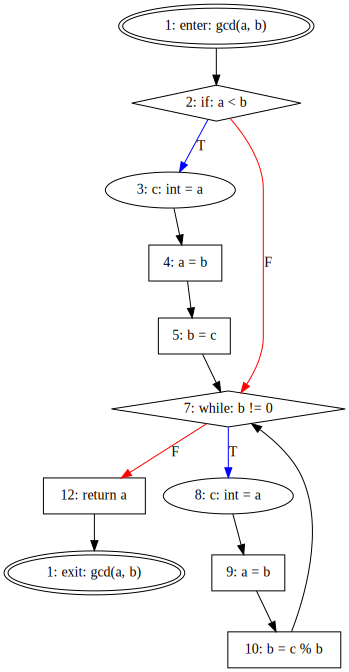

In [183]:
def gcd(a: int, b: int) -> int:
    if a< b:
        c:int = a
        a = b 
        b = c
    
    while b != 0:
        c:int = a
        a = b
        b = c % b
    
    return a

show_cfg(gcd)

In [184]:
from fuzzingbook.ExpectError import ExpectError

with ExpectError():
    symfz_gcd = SimpleSymbolicFuzzer(gcd, max_depth = 1000, max_iter = 10)

    '''
    这里的问题在于，我们的SimpleSymbolicFuzzer没有循环和可变重新分配的概念。接下来解决这个问题
    '''

    for i in range(1,100):
        r = symfz_gcd.fuzz()
        v = gcd(r['a'].as_long(), r['b'].as_long())
        print(r,v)

Traceback (most recent call last):
  File "/tmp/ipykernel_36920/3970762543.py", line 4, in <cell line: 3>
    symfz_gcd = SimpleSymbolicFuzzer(gcd, max_depth = 1000, max_iter = 10)
  File "/tmp/ipykernel_36920/2723709324.py", line 51, in __init__
    self.process()
  File "/tmp/ipykernel_36920/2723709324.py", line 60, in process
    self.paths = self.get_all_paths(self.fnenter)
  File "/tmp/ipykernel_36920/2723709324.py", line 71, in get_all_paths
    child_paths = self.get_all_paths(child, depth + 1)
  File "/tmp/ipykernel_36920/2723709324.py", line 71, in get_all_paths
    child_paths = self.get_all_paths(child, depth + 1)
  File "/tmp/ipykernel_36920/2723709324.py", line 71, in get_all_paths
    child_paths = self.get_all_paths(child, depth + 1)
  [Previous line repeated 998 more times]
  File "/tmp/ipykernel_36920/2723709324.py", line 65, in get_all_paths
    raise Exception('Maximum depth exceeded')
Exception: Maximum depth exceeded (expected)


In [185]:
class SymbolicFuzzer(SimpleSymbolicFuzzer):
    
    def options(self, kwargs):
        super().options(kwargs)
    

def rename_variables(astnode, env):
    if isinstance(astnode, ast.BoolOp):
        fn = 'z3.And' if isinstance(astnode.op, ast.And) else 'z3.Or'
        return ast.Call(
            ast.Name(fn, None),
            [rename_variables(i, env) for i in astnode.values], [])
    elif isinstance(astnode, ast.BinOp):
        return ast.BinOp(
            rename_variables(astnode.left, env), astnode.op,
            rename_variables(astnode.right, env))
    elif isinstance(astnode, ast.UnaryOp):
        if isinstance(astnode.op, ast.Not):
            return ast.Call(
                ast.Name('z3.Not', None),
                [rename_variables(astnode.operand, env)], [])
        else:
            return ast.UnaryOp(astnode.op,
                               rename_variables(astnode.operand, env))
    elif isinstance(astnode, ast.Call):
        return ast.Call(astnode.func,
                        [rename_variables(i, env) for i in astnode.args],
                        astnode.keywords)
    elif isinstance(astnode, ast.Compare):
        return ast.Compare(
            rename_variables(astnode.left, env), astnode.ops,
            [rename_variables(i, env) for i in astnode.comparators])
    elif isinstance(astnode, ast.Name):
        if astnode.id not in env:
            env[astnode.id] = 0
        num = env[astnode.id]
        return ast.Name('_%s_%d' % (astnode.id, num), astnode.ctx)
    elif isinstance(astnode, ast.Return):
        return ast.Return(rename_variables(astnode.value, env))
    else:
        return astnode



In [186]:
ba = get_expression('x == 1 and y == 2')
type(ba)

_ast.BoolOp

In [187]:
assert to_src(rename_variables(ba, env)) == 'z3.And(_x_1 == 1, _y_0 == 2)'

AssertionError: 

In [188]:
bo = get_expression('x == 1 or y == 2')
type(bo.op)

_ast.Or

In [189]:
assert to_src(rename_variables(bo, env)) == 'z3.Or(_x_1 == 1, _y_0 == 2)'

AssertionError: 

In [190]:
class PNode:
    def __init__(self, idx, cfgnode, parent=None, order=0, seen=None) -> None:
        self.seen = {} if seen is None else seen
        self.max_iter = MAX_ITER
        self.idx, self.cfgnode, self.parent, self.order = idx, cfgnode, parent, order

    def __repr__(self):
        return "PNode:%d[%s order:%d]" % (self.idx, str(self.cfgnode),
                                          self.order)

cfg = PyCFG()
cfg.gen_cfg(inspect.getsource(gcd))
gcd_fnenter, _ = cfg.functions['gcd']  
PNode(0, gcd_fnenter)

PNode:0[id:27 line[1] parents: [] : enter: gcd(a, b) order:0]

In [191]:
class PNode(PNode):
    def copy(self, order):
        p = PNode(self.idx, self.cfgnode, self.parent, order, self.seen)
        assert p.order == order
        return p

PNode(0, gcd_fnenter).copy(1)

PNode:0[id:27 line[1] parents: [] : enter: gcd(a, b) order:1]

In [192]:
class PNode(PNode):
    def explore(self):
        ret = []
        for (i, n) in enumerate(self.cfgnode.children):
            key = "[%d]%s" % (self.idx + 1, n)
            ccount = self.seen.get(key, 0)
            if ccount > self.max_iter:
                continue  # drop this child
            self.seen[key] = ccount + 1
            pn = PNode(self.idx + 1, n, self.copy(i), seen=self.seen)
            ret.append(pn)
        return ret

PNode(0, gcd_fnenter).explore()
PNode(0, gcd_fnenter).explore()[0].explore()

[PNode:2[id:30 line[3] parents: [29] : c: int = a order:0],
 PNode:2[id:33 line[7] parents: [32, 29, 36] : _while: b != 0 order:0]]

In [193]:
class PNode(PNode):
    def get_path_to_root(self):
        path = []
        n = self
        while n:
            path.append(n)
            n = n.parent
        return list(reversed(path))

p = PNode(0, gcd_fnenter)
[s.get_path_to_root() for s in p.explore()[0].explore()[0].explore()[0].explore()]

[[PNode:0[id:27 line[1] parents: [] : enter: gcd(a, b) order:0],
  PNode:1[id:29 line[2] parents: [27] : _if: a < b order:0],
  PNode:2[id:30 line[3] parents: [29] : c: int = a order:0],
  PNode:3[id:31 line[4] parents: [30] : a = b order:0],
  PNode:4[id:32 line[5] parents: [31] : b = c order:0]]]

In [194]:
def to_single_assignment_predicates(path):
    env = {}
    new_path = []
    for i, node in enumerate(path):
        ast_node = node.cfgnode.ast_node
        new_node = None
        if isinstance(ast_node, ast.AnnAssign) and ast_node.target.id in {
                'exit'}:
            new_node = None
        elif isinstance(ast_node, ast.AnnAssign) and ast_node.target.id in {'enter'}:
            args = [
                ast.parse(
                    "%s == _%s_0" %
                    (a.id, a.id)).body[0].value for a in ast_node.annotation.args]
            new_node = ast.Call(ast.Name('z3.And', None), args, [])
        elif isinstance(ast_node, ast.AnnAssign) and ast_node.target.id in {'_if', '_while'}:
            new_node = rename_variables(ast_node.annotation, env)
            if node.order != 0:
                assert node.order == 1
                new_node = ast.Call(ast.Name('z3.Not', None), [new_node], [])
        elif isinstance(ast_node, ast.AnnAssign):
            assigned = ast_node.target.id
            val = [rename_variables(ast_node.value, env)]
            env[assigned] = 0 if assigned not in env else env[assigned] + 1
            target = ast.Name('_%s_%d' %
                              (ast_node.target.id, env[assigned]), None)
            new_node = ast.Expr(ast.Compare(target, [ast.Eq()], val))
        elif isinstance(ast_node, ast.Assign):
            assigned = ast_node.targets[0].id
            val = [rename_variables(ast_node.value, env)]
            env[assigned] = 0 if assigned not in env else env[assigned] + 1
            target = ast.Name('_%s_%d' %
                              (ast_node.targets[0].id, env[assigned]), None)
            new_node = ast.Expr(ast.Compare(target, [ast.Eq()], val))
        elif isinstance(ast_node, (ast.Return, ast.Pass)):
            new_node = None
        else:
            s = "NI %s %s" % (type(ast_node), ast_node.target.id)
            raise Exception(s)
        new_path.append(new_node)
    return new_path

class PNode(PNode):
    def __str__(self):
        path = self.get_path_to_root()
        ssa_path = to_single_assignment_predicates(path)
        return ', '.join([to_src(p) for p in ssa_path])

In [195]:
p = PNode(0, gcd_fnenter)
path = p.explore()[0].explore()[0].explore()[0].get_path_to_root()
spath = to_single_assignment_predicates(path)

[to_src(s) for s in spath]

['z3.And((a == _a_0), (b == _b_0))',
 '(_a_0 < _b_0)',
 '(_c_0 == _a_0)',
 '(_a_1 == _b_0)']

协程执行简化符号执行的方式之一是对循环的处理。我们不是试图确定一个循环的不变量，而是简单地将循环展开若干次，直到达到MAX_DEPTH的限制。然而，并不是所有的循环都需要被展开，直到达到MAX_DEPTH。有些可能会在之前退出。因此，在继续进一步探索之前，有必要检查是否可以满足给定的约束集。

In [196]:
def identifiers_with_types(identifiers, defined):
    with_types = dict(defined)

    for i in identifiers:
        if i[0] == '_':
            nxt = i[1:].find('_', 1)
            name = i[1:nxt + 1]
            assert name in defined
            typ = defined[name]
            with_types[i] = typ
    return with_types            

extract_constraints()从路径中生成了z3约束。主要工作是由to_single_assignment_predicates()完成的。然后，extract_constraints()将AST转换为源代码。

In [197]:
class SymbolicFuzzer(SymbolicFuzzer):
    def extract_constraints(self, path):
        return [to_src(p) for p in to_single_assignment_predicates(path) if p]

In [198]:
class SymbolicFuzzer(SymbolicFuzzer):
    def solve_path_constraint(self, path):
        # re-initializing does not seem problematic.
        # a = z3.Int('a').get_id() remains the same.
        constraints = self.extract_constraints(path)
        identifiers = [
            c for i in constraints for c in used_identifiers(i)]  # <- changes
        with_types = identifiers_with_types(
            identifiers, self.used_variables)  # <- changes
        decl = define_symbolic_vars(with_types, '')
        exec(decl)

        solutions = {}
        with checkpoint(self.z3):
            st = 'self.z3.add(%s)' % ', '.join(constraints)
            eval(st)
            if self.z3.check() != z3.sat:
                return {}
            m = self.z3.model()
            solutions = {d.name(): m[d] for d in m.decls()}
            my_args = {k: solutions.get(k, None) for k in self.fn_args}

        predicate = 'z3.And(%s)' % ','.join(
            ["%s == %s" % (k, v) for k, v in my_args.items()])
        eval('self.z3.add(z3.Not(%s))' % predicate)

        return my_args
    
    def get_all_paths(self, fenter):
        path_lst = [PNode(0, fenter)]
        completed = []
        for i in range(self.max_iter):
            new_paths = [PNode(0, fenter)]
            for path in path_lst:
                # explore each path once
                if path.cfgnode.children:
                    np = path.explore()
                    for p in np:
                        if path.idx > self.max_depth:
                            break
                        new_paths.append(p)
                else:
                    completed.append(path)
            path_lst = new_paths
        return completed + path_lst   

In [199]:
asymfz_gcd = SymbolicFuzzer(
    gcd, max_iter=10, max_tries=10, max_depth=10)
all_paths = asymfz_gcd.get_all_paths(asymfz_gcd.fnenter)

In [200]:
len(all_paths)

38

In [201]:
all_paths[37].get_path_to_root()

[PNode:0[id:40 line[1] parents: [] : enter: gcd(a, b) order:0],
 PNode:1[id:42 line[2] parents: [40] : _if: a < b order:1],
 PNode:2[id:46 line[7] parents: [45, 42, 49] : _while: b != 0 order:0],
 PNode:3[id:47 line[8] parents: [46] : c: int = a order:0],
 PNode:4[id:48 line[9] parents: [47] : a = b order:0],
 PNode:5[id:49 line[10] parents: [48] : b = c % b order:0],
 PNode:6[id:46 line[7] parents: [45, 42, 49] : _while: b != 0 order:0],
 PNode:7[id:47 line[8] parents: [46] : c: int = a order:0],
 PNode:8[id:48 line[9] parents: [47] : a = b order:0],
 PNode:9[id:49 line[10] parents: [48] : b = c % b order:0],
 PNode:10[id:46 line[7] parents: [45, 42, 49] : _while: b != 0 order:0]]

In [202]:
for s in to_single_assignment_predicates(all_paths[37].get_path_to_root()):
    if s is not None:
        print(to_src(s))

z3.And((a == _a_0), (b == _b_0))
z3.Not((_a_0 < _b_0))
(_b_0 != 0)
(_c_0 == _a_0)
(_a_1 == _b_0)
(_b_1 == (_c_0 % _b_0))
(_b_1 != 0)
(_c_1 == _a_1)
(_a_2 == _b_1)
(_b_2 == (_c_1 % _b_1))
(_b_2 != 0)


In [203]:
constraints = asymfz_gcd.extract_constraints(all_paths[37].get_path_to_root())

constraints

['z3.And((a == _a_0), (b == _b_0))',
 'z3.Not((_a_0 < _b_0))',
 '(_b_0 != 0)',
 '(_c_0 == _a_0)',
 '(_a_1 == _b_0)',
 '(_b_1 == (_c_0 % _b_0))',
 '(_b_1 != 0)',
 '(_c_1 == _a_1)',
 '(_a_2 == _b_1)',
 '(_b_2 == (_c_1 % _b_1))',
 '(_b_2 != 0)']

In [204]:
class SymbolicFuzzer(SymbolicFuzzer):
    def get_next_path(self):
        self.last_path -= 1
        if self.last_path == -1:
            self.last_path = len(self.paths) - 1
        return self.paths[self.last_path].get_path_to_root()

In [205]:
asymfz_gcd = SymbolicFuzzer(
    gcd, max_tries=10, max_iter=10, max_depth=10)
data = []
for i in range(10):
    r = asymfz_gcd.fuzz()
    data.append((r['a'].as_long(), r['b'].as_long()))
    v = gcd(*data[-1])
    print(r, "result:", repr(v))

NameError: name '_a_0' is not defined

In [206]:
from fuzzingbook.SymbolicFuzzer import AdvancedSymbolicFuzzer

asymfz_gcd = AdvancedSymbolicFuzzer(
    gcd, max_tries=10, max_iter=10, max_depth=10)
data = []
for i in range(10):
    r = asymfz_gcd.fuzz()
    data.append((r['a'].as_long(), r['b'].as_long()))
    v = gcd(*data[-1])
    print(r, "result:", repr(v))

{'a': 8, 'b': 3} result: 1
{'a': 2, 'b': 4} result: 2
{'a': 2, 'b': 5} result: 1
{'a': 7, 'b': 6} result: 1
{'a': 9, 'b': 10} result: 1
{'a': 11, 'b': 11} result: 11
{'a': 3, 'b': 2} result: 1
{'a': 3, 'b': 7} result: 1
{'a': 4, 'b': 1} result: 1
{'a': 10, 'b': 9} result: 1


In [208]:
class VisualizedArcCoverage(ArcCoverage):
    def show_coverage(self, fn):
        src = fn if isinstance(fn, str) else inspect.getsource(fn)
        covered = set([lineno for method, lineno in self._trace])
        for i, s in enumerate(src.split('\n')):
            print('%s %2d: %s' % ('#' if i + 1 in covered else ' ', i + 1, s))

with VisualizeArcCoverage() as cov:
    for a, b in data:
        gcd(a, b)

cov.show_coverage(gcd)

#  1: def gcd(a: int, b: int) -> int:
#  2:     if a< b:
#  3:         c:int = a
#  4:         a = b 
#  5:         b = c
   6:     
#  7:     while b != 0:
#  8:         c:int = a
#  9:         a = b
# 10:         b = c % b
  11:     
# 12:     return a
  13: 


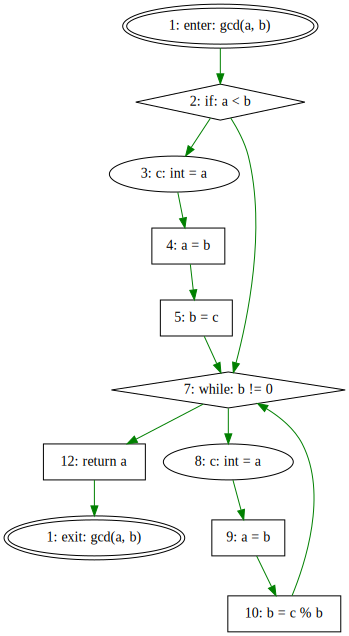

In [209]:
show_cfg(gcd, arcs=cov.arcs())